In [199]:
# !pip install optuna

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, confusion_matrix
import optuna

In [8]:
df= pd.read_csv(r"C:\Users\dell\Desktop\new data kerala.csv")

In [11]:
df["log_Mean_Intensity"] = np.log10(df["Mean Intensity"])
df["log_Duration"] = np.log10(df["Duration"])
print(df.shape)
df.head()

(4144, 5)


,Mean Intensity,Duration,Label,log_Mean_Intensity,log_Duration
0,5.278308,65,1,0.722495,1.812913
1,5.343077,13,1,0.727791,1.113943
2,3.869231,65,1,0.587625,1.812913
3,2.604286,14,1,0.415689,1.146128
4,4.261111,9,1,0.629523,0.954243


In [13]:
df["Label"].value_counts()

Label
0    3636
1     508
Name: count, dtype: int64

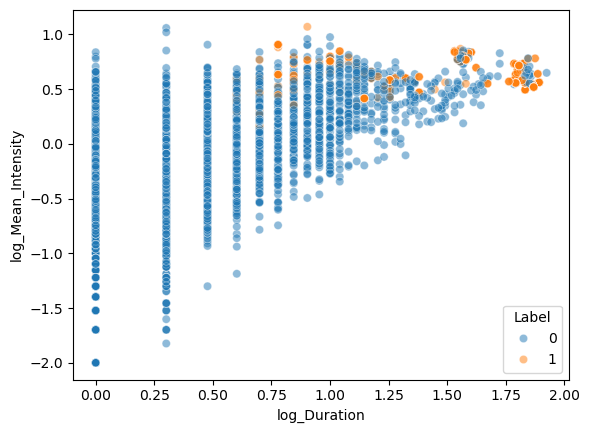

In [15]:
sns.scatterplot(data=df, x="log_Duration", y="log_Mean_Intensity", hue="Label", alpha=0.5);

In [17]:
X = df[["log_Duration", "log_Mean_Intensity"]]
y = df["Label"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3315, 2), (829, 2), (3315,), (829,))

In [21]:
y_train.value_counts()

Label
0    2907
1     408
Name: count, dtype: int64

In [23]:
triggered_index = y_train[y_train == 1].index

X_train_triggered = X[X.index.isin(triggered_index)]
y_train_triggered = y_train[y_train==1]
X_train_triggered.shape, y_train_triggered.shape

((408, 2), (408,))

In [25]:
def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ['l2']),
        "tol": trial.suggest_float("tol", 1e-8, 1),
        "C": trial.suggest_float("C", 1, 100), 
        "max_iter": trial.suggest_int("max_iter", 10, 200)
    }

    lr = LogisticRegression(**params)

    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train_triggered)

    acc = accuracy_score(y_train_triggered, y_pred)

    return acc

In [27]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = 'maximize' , study_name = 'Logistic Regression', pruner = optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials = 100)

In [28]:
study.best_params

{'penalty': 'l2',
 'tol': 0.0009305074867259382,
 'C': 57.33423322823328,
 'max_iter': 197}

In [31]:
lr = LogisticRegression(**study.best_params)
lr.fit(X, y)

LogisticRegression(C=57.33423322823328, max_iter=197, tol=0.0009305074867259382)

In [33]:
y_pred = lr.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       732
           1       0.71      0.73      0.72        97

    accuracy                           0.93       829
   macro avg       0.84      0.85      0.84       829
weighted avg       0.93      0.93      0.93       829



In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[703,  26],
       [ 29,  71]], dtype=int64)

In [37]:
lr.coef_

array([[2.15523551, 6.1390615 ]])

In [39]:
lr.intercept_

array([-6.29091703])

In [43]:
X["log_Duration"].values.flatten()*lr.coef_[0][0]

array([3.90725525, 2.40081027, 3.90725525, ..., 0.        , 2.15523551,
       0.        ])

C:\Users\dell\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


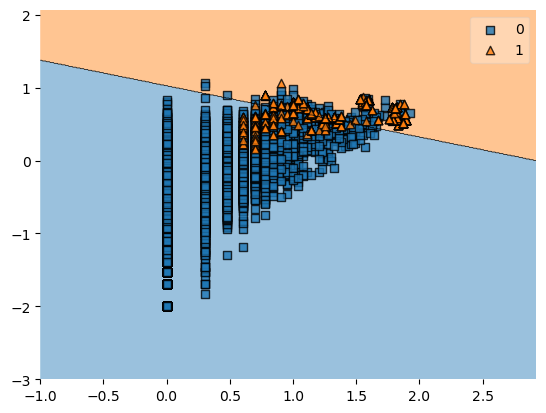

In [45]:
plot_decision_regions(X.values, y.values, lr);

In [47]:
y_pred_all = lr.predict(X)
y_pred_prob_all = lr.predict_proba(X)[:, 1]
df["landslide_probability"] = y_pred_prob_all
df

,Mean Intensity,Duration,Label,log_Mean_Intensity,log_Duration,landslide_probability
0,5.278308,65,1,0.722495,1.812913,0.886127
1,5.343077,13,1,0.727791,1.113943,0.640572
2,3.869231,65,1,0.587625,1.812913,0.772732
3,2.604286,14,1,0.415689,1.146128,0.219462
4,4.261111,9,1,0.629523,0.954243,0.408633
...,...,...,...,...,...,...
4139,0.950000,6,0,-0.022276,0.778151,0.008573
4140,0.400000,1,0,-0.397940,0.000000,0.000161
4141,1.670000,1,0,0.222716,0.000000,0.007220
4142,4.346000,10,0,0.638090,1.000000,0.445614


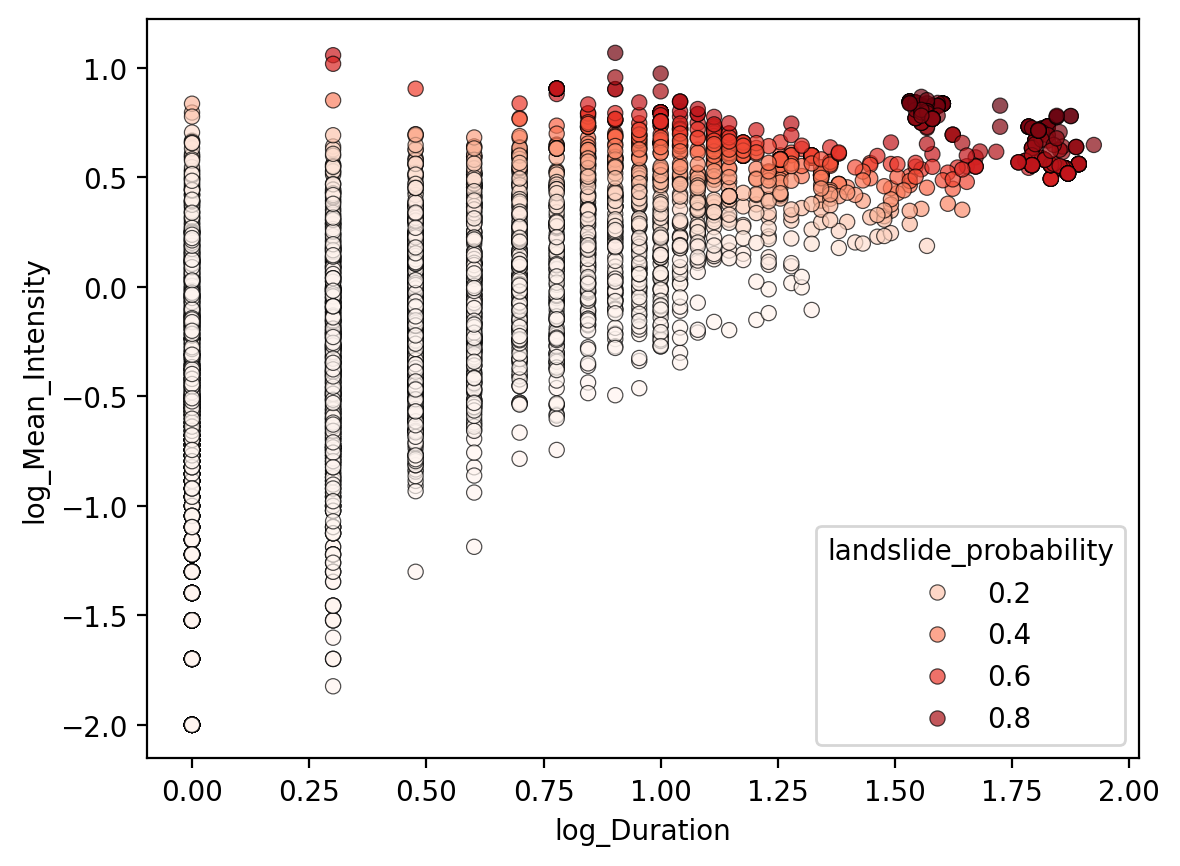

In [51]:
plt.figure(dpi=200)
sns.scatterplot(df, x="log_Duration", y="log_Mean_Intensity", hue="landslide_probability", palette="Reds", 
                edgecolor="k", alpha=0.7, s=30);

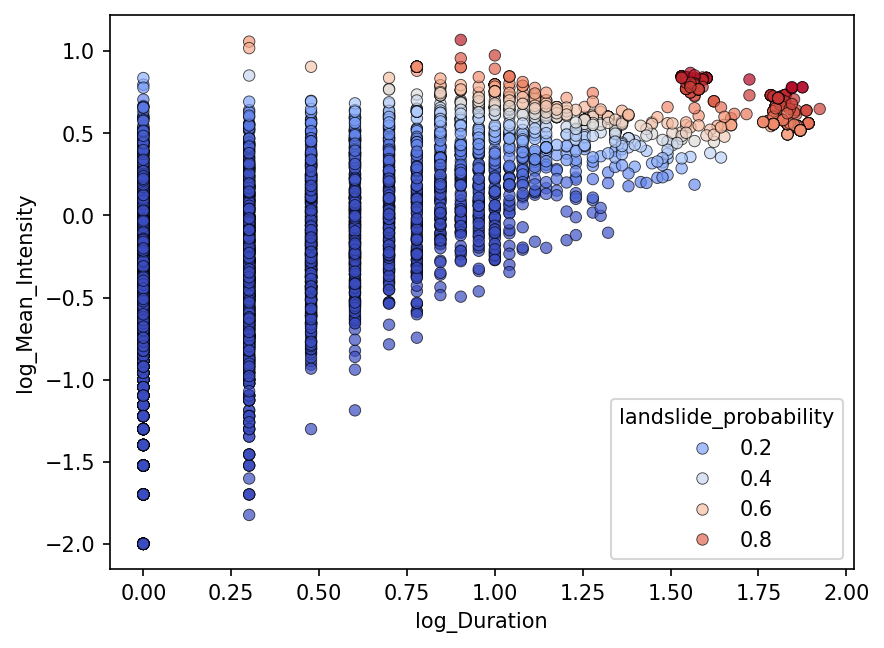

In [53]:
plt.figure(dpi=150)
sns.scatterplot(df, x="log_Duration", y="log_Mean_Intensity", hue="landslide_probability", palette="coolwarm",
                edgecolor="k", alpha=0.7, s=30);

In [81]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'df' contains your original dataset with 'Mean Intensity' and 'Duration' columns
# Calculate log-transformed columns if not already done
df['log_Mean_Intensity'] = np.log10(df['Mean Intensity'])
df['log_Duration'] = np.log10(df['Duration'])

# Calculate the intensity predicted by the equation I = 8.66 * D^(-0.5325)
df['Predicted_Intensity'] = 8.66 * (df['Duration'] ** -0.5325)

# Calculate logistic regression predictions (probabilities of landslide occurrence)
# Assumes 'lr' is your trained LogisticRegression model
X = df[['log_Duration', 'log_Mean_Intensity']]
df['Logistic_Prob'] = lr.predict_proba(X)[:, 1]  # Probability of landslide occurrence

# Calculate error metrics to compare Predicted_Intensity vs Mean Intensity
mae = mean_absolute_error(df['Mean Intensity'], df['Predicted_Intensity'])
mse = mean_squared_error(df['Mean Intensity'], df['Predicted_Intensity'])

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")


Mean Absolute Error (MAE): 4.581824399135444
Mean Squared Error (MSE): 27.860871867842572


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Instantiate and fit an SVM with a linear kernel
svc_linear = SVC(kernel='linear', random_state=0)
svc_linear.fit(X_train, y_train)

# Predict on the test data and calculate accuracy
y_pred = svc_linear.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Function to plot the decision boundary for a 2D SVM
def plot_svc_decision_boundary(model, X, y, title="Decision Boundary"):
    plt.figure(figsize=(8, 6))
    
    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=50)
    
    # Create mesh grid for plotting decision boundaries
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), 
                         np.linspace(ylim[0], ylim[1], 100))
    
    # Predict on each point in the mesh grid
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and margins
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    
    # Plot support vectors
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
                s=100, linewidth=1, facecolors='none', edgecolors='k')
    
    # Labels and title
    plt.xlabel('Log Duration')
    plt.ylabel('Log Mean Intensity')
    plt.title(title)
    plt.colorbar(scatter)
    plt.show()

# Plot the decision boundary
plot_svc_decision_boundary(svc_linear, X_test.values, y_test.values, 
                           title=f"SVM Decision Boundary with Linear Kernel (Accuracy: {accuracy:.2f})")
